# Static Mortality Categorisation

Benjamin Frost 2022


In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from Categorization import Categorizer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import copy
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset, random_split
import imblearn
from collections import Counter
from importlib import reload


### Loading in the data

In [2]:
mimicDF = pd.read_csv('../LEN_Test/data/StaticData.csv')
targetDF = mimicDF[['deathperiod']]

ids = mimicDF['PatientID']

mimicDF = mimicDF.drop(columns=['PatientID', 'deathperiod'])

categorisationTypes = {}

In [3]:
mimicDF.head()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,NaN,0.0,3.0,3.0
1,2,0,75.00,4,2,NaN,0.0,0.0,1.0,NaN,1.0
2,16,0,51.92,4,2,NaN,0.0,NaN,0.0,NaN,2.0
3,12,0,51.73,-13,4,2.0,2.0,NaN,0.0,NaN,0.0
4,7,0,62.07,0,3,0.0,2.0,NaN,1.0,NaN,0.0


### Finding values in need of cleaning

In [4]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,3311.000000,5227.000000,2254.000000,5261.000000,1294.000000,5212.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,1.987315,0.674957,0.696983,1.017297,3.238022,0.768611
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.374066,0.892066,1.051290,1.263514,0.706116,1.140061
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [5]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 4778 containing NaN values


### Missing values dealt with by filling with the mode.

In [6]:
mimicDF['age'] = mimicDF['age'].fillna(mimicDF['age'].mean())

for col in mimicDF:
    mimicDF[col] = mimicDF[col].fillna(mimicDF[col].mode()[0])

mimicDF['comorbidity'][mimicDF['comorbidity'] < 0] = mimicDF['comorbidity'][mimicDF['comorbidity'] < 0] * -1

C:\Users\benma\AppData\Local\Temp/ipykernel_18804/4017263199.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['comorbidity'][mimicDF['comorbidity'] < 0] = mimicDF['comorbidity'][mimicDF['comorbidity'] < 0] * -1


In [7]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.00000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,0.382554,75.049002,10.553972,4.794185,2.36279,0.670468,0.298556,1.017104,3.058533,0.761307
std,14.101457,0.486057,50.553676,8.843506,2.694694,1.19465,0.890785,0.769595,1.263472,0.364759,1.137079
min,1.000000,0.000000,16.010000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,3.000000,3.000000,2.00000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,3.00000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.00000,1.000000,0.000000,2.000000,3.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000


### All missing values filled

In [8]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 0 containing NaN values


In [9]:
targetDF.describe()

,deathperiod
count,5262.000000
mean,0.896047
std,7.338713
min,-29.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,107.000000


In [10]:
targetDF

,deathperiod
0,-1
1,2
2,-1
3,-1
4,-1
...,...
5257,-1
5258,-1
5259,-1
5260,-1


### Exploring raw target data

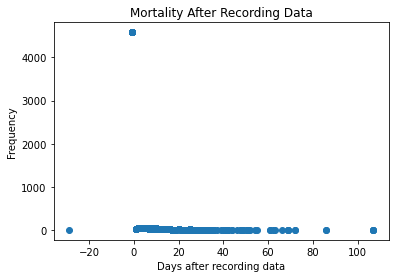

In [11]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()))
plt.xlabel("Days after recording data")
plt.ylabel("Frequency")
plt.title("Mortality After Recording Data")
plt.show()

In [12]:
targetDF['deathperiod'] = targetDF['deathperiod'].apply(lambda x: x if x > -1 else -1)

targetDiedDF = targetDF[targetDF['deathperiod'] > -1]
targetNoDeathDF = targetDF[targetDF['deathperiod'] == -1].apply(lambda x: x+1.0)

### Sanity Checks

In [13]:
targetDiedDF.shape

(678, 1)

In [14]:
targetNoDeathDF.shape

(4584, 1)

### Categorising target data

In [15]:
bins = 3

cat = Categorizer(targetDiedDF)
targetCategorisedDF = cat.kBins(bins=bins, strategy='quantile')

targetCategorisedDF['deathperiod'] = targetCategorisedDF['deathperiod'].apply(lambda x: x + 1)

targetCategorisedDF.set_index(targetDiedDF.index, inplace=True)

targetCategorisedDF.head()

,deathperiod
1,1.0
7,3.0
16,2.0
36,3.0
40,2.0


In [16]:
targetNoDeathDF.head()

,deathperiod
0,0.0
2,0.0
3,0.0
4,0.0
5,0.0


### Combining death and no death target data

In [17]:
combinedTargetDF = targetCategorisedDF.merge(targetNoDeathDF, how='outer', left_index=True, right_index=True).rename(columns={'deathperiod_x': 'deathperiod'})

withDeath = combinedTargetDF.iloc[:,0]
noDeath = combinedTargetDF.iloc[:,1]

newTargetDF = withDeath.fillna(noDeath)

newTargetDF = newTargetDF.astype(np.int64)

newTargetDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

### Simple version of target data (Used in the final dataset)

In [18]:
simpleNewTargetDF = targetDF['deathperiod'].apply(lambda x: 0 if x < 0 else 1)

simpleNewTargetDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

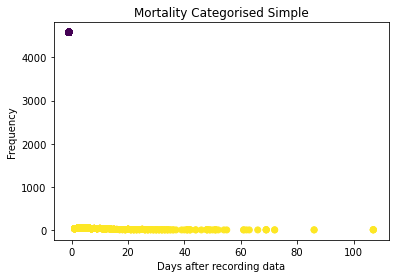

In [19]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=simpleNewTargetDF)
plt.xlabel("Days after recording data")
plt.ylabel("Frequency")
plt.title("Mortality Categorised Simple")
plt.show()

In [20]:
simpleNewTargetDF.value_counts()

0    4584
1     678
Name: deathperiod, dtype: int64

### Starting data categorization

In [21]:
dataNeedingEncodingDF = mimicDF[['los', 'age', 'comorbidity', 'sofa']]

### Fixing high age range

In [22]:
ageWithoutOutliers = dataNeedingEncodingDF['age'][dataNeedingEncodingDF['age'] < 200]

dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))

dataNeedingEncodingDF.head()

C:\Users\benma\AppData\Local\Temp/ipykernel_18804/2166811324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))


,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,13,4
4,7,62.07,0,3


### Exploring clustering in 2d here, wasn't used in the final dataset

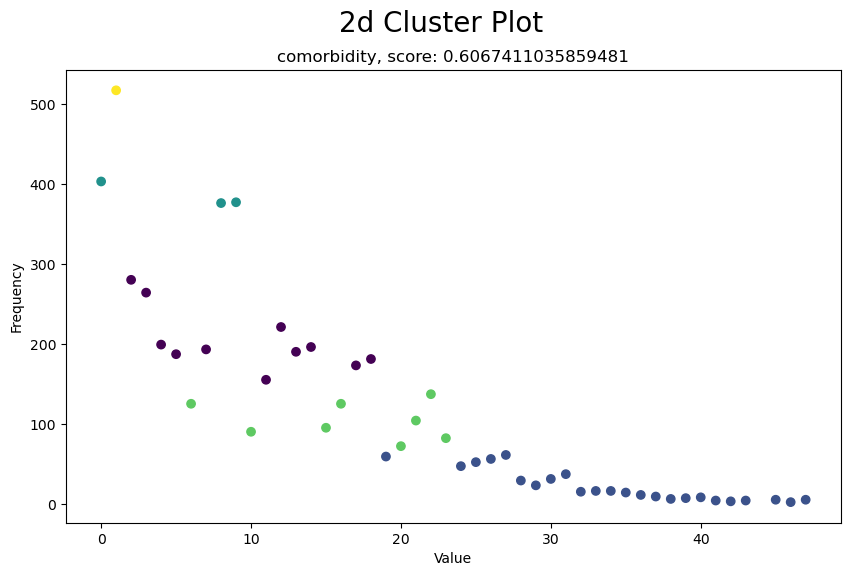

In [23]:
comorbidity = dataNeedingEncodingDF[['comorbidity']]

comorbidity = pd.DataFrame(data=list(zip(comorbidity.value_counts().index, comorbidity.value_counts().values)), columns=['comorbidity', 'count'])

comorbidity['comorbidity'] = comorbidity['comorbidity'].astype(str).apply(lambda x: x[1:-2]).astype(np.int64)

comorbidityDF = AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(comorbidity))

sil_x = np.dstack((comorbidity['comorbidity'], comorbidity['count']))[0]

score = silhouette_score(sil_x, comorbidityDF)

fig = plt.figure(figsize=(10,6), dpi=100)
fig.suptitle("2d Cluster Plot", fontsize=20)

plt.scatter(comorbidity['comorbidity'], comorbidity['count'], c=comorbidityDF)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"comorbidity, score: {score}")
plt.show()

In [24]:
dataNeedingEncodingDF

,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,13,4
4,7,62.07,0,3
...,...,...,...,...
5257,120,36.61,5,10
5258,13,53.90,12,4
5259,4,58.93,18,5
5260,16,68.98,4,3


# Graphically representing the categorisation

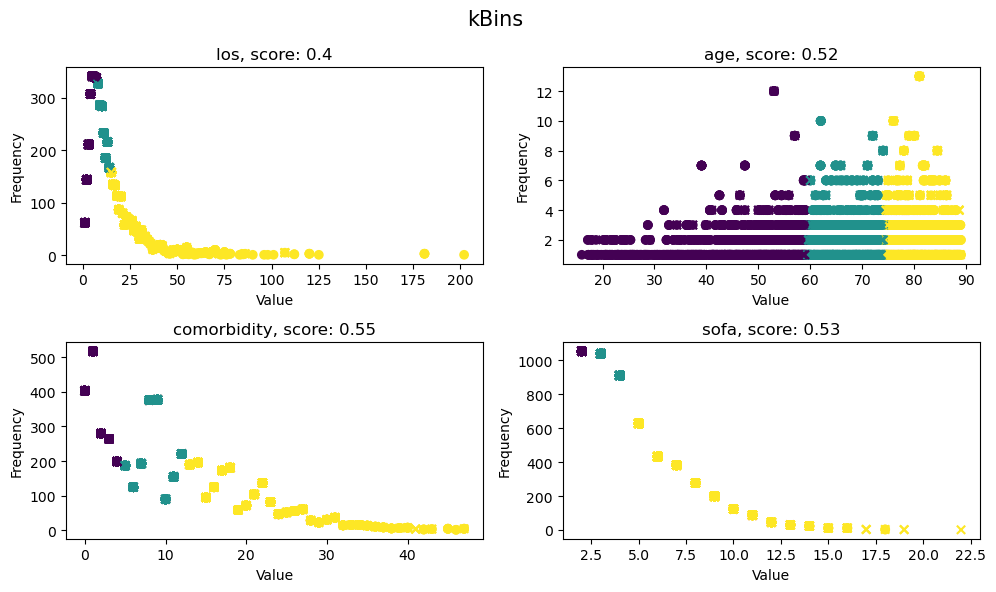

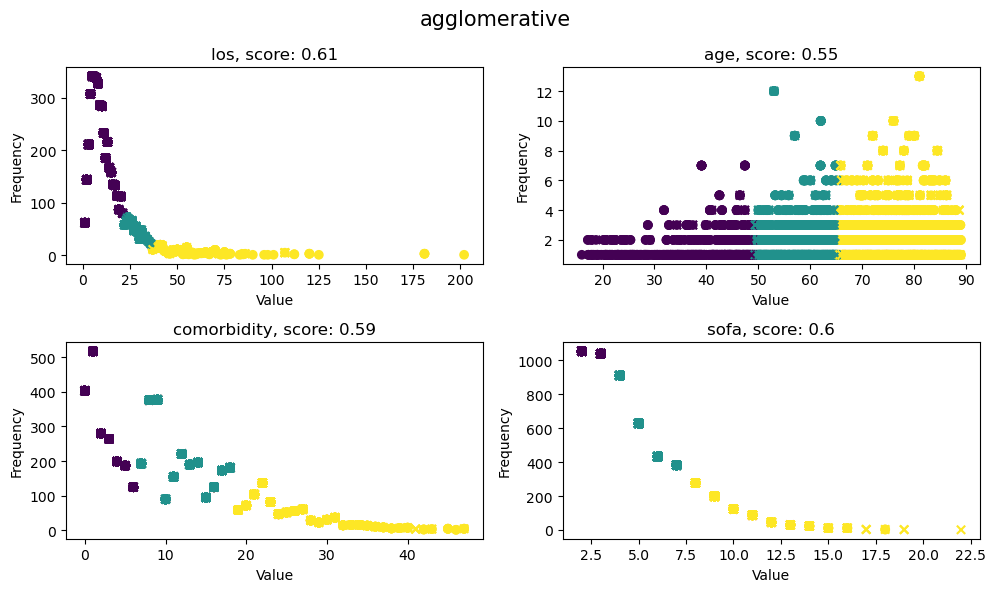

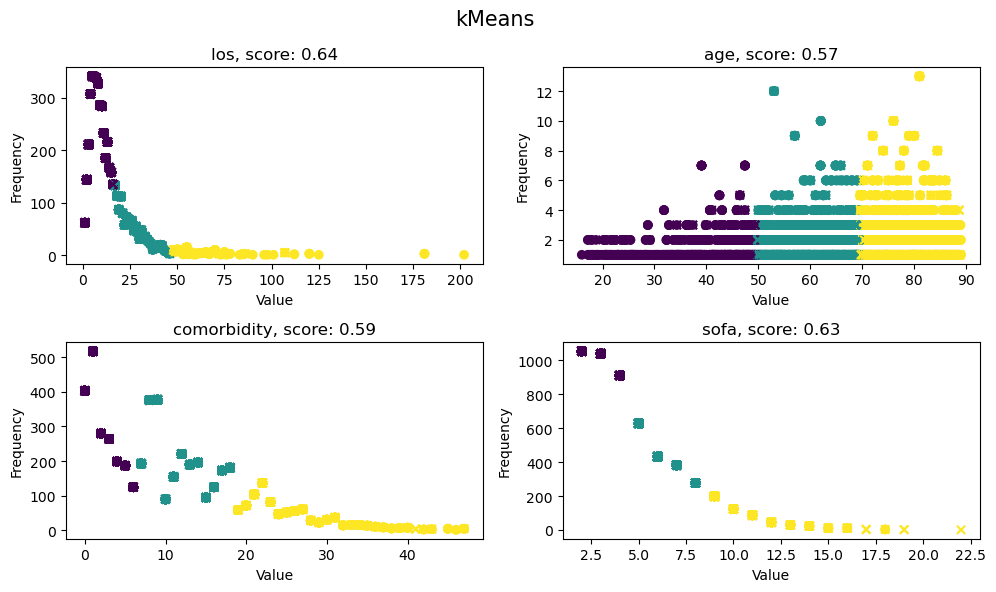

In [25]:
cat = Categorizer(dataNeedingEncodingDF)

clusters = 3

kBinsDF = cat.kBins(bins=clusters, strategy='quantile')
aggDF = cat.agglomerative(n_clusters=clusters)
kMeansDF = cat.kMeans(n_clusters=clusters)

cat.display(target=simpleNewTargetDF)

### Computing the boundaries of the categorised data.

In [26]:
boundaries = cat.getBoundaries()
for type in boundaries:
    print(f"{type}: {boundaries[type]}")

kBins: {'los': [8.0, 15.0], 'age': [59.25, 74.38], 'comorbidity': [5.0, 13.0], 'sofa': [3.0, 5.0]}
agglomerative: {'los': [22, 37], 'age': [49.08, 65.2], 'comorbidity': [7, 19], 'sofa': [4, 8]}
kMeans: {'los': [17, 47], 'age': [49.55, 69.43], 'comorbidity': [7, 19], 'sofa': [5, 9]}


### Labelling categorised data

In [27]:
categories = {0: 'low', 1: 'medium', 2: 'high'}

mapped = cat.map_types(data={'agg': cat.categorizationTypes['agglomerative']}, mapping=categories)['agg']

mapped

,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,sofa_low,sofa_medium
0,0,1,0,1,0,0,0,0,1,0,0,1
1,0,1,0,1,0,0,0,1,0,0,1,0
2,0,1,0,0,0,1,0,1,0,0,1,0
3,0,1,0,0,0,1,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,1,0,0,1,0,1,0,0
5258,0,1,0,0,0,1,0,0,1,0,0,1
5259,0,1,0,0,0,1,0,0,1,0,0,1
5260,0,1,0,1,0,0,0,1,0,0,1,0


In [28]:
mapped['Mortality14Days'] = simpleNewTargetDF

mapped['PatientID'] = ids

mapped = mapped.set_index('PatientID')

mapped

,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,sofa_low,sofa_medium,Mortality14Days
PatientID,,,,,,,,,,,,,
181199,0,1,0,1,0,0,0,0,1,0,0,1,0
167020,0,1,0,1,0,0,0,1,0,0,1,0,1
169463,0,1,0,0,0,1,0,1,0,0,1,0,0
183338,0,1,0,0,0,1,0,0,1,0,0,1,0
192665,0,1,0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106017,1,0,0,0,1,0,0,1,0,1,0,0,0
186511,0,1,0,0,0,1,0,0,1,0,0,1,0
188867,0,1,0,0,0,1,0,0,1,0,0,1,0


In [29]:
dataname = "staticData.csv"

mapped.to_csv(f"./categorisedData/{dataname}")